In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# M1 L2/3

In [364]:
with open('python/methods.py', 'r') as file:
    exec(file.read())

In [365]:
samples = pd.read_csv('sample_sheet.csv')
samples = samples[ samples['Type'] == 'M1_L2/3' ]
samples

,SID,AnimalID,CellName,Type,Date,Depth,Count
20,W1_C3,W1,C3,M1_L2/3,2019 12 09,305.290403,310
21,W1_C4,W1,C4,M1_L2/3,2019 12 09,374.226946,380
22,W1_C5,W1,C5,M1_L2/3,2019 12 09,216.657706,220
23,W1_C6,W1,C6,M1_L2/3,2019 12 09,305.290403,310
24,W2_C1,W2,C1,M1_L2/3,2019 12 12,142.797124,145
25,W2_C2,W2,C2,M1_L2/3,2019 12 12,315.138481,320
26,W3_C1,W3,C1,M1_L2/3,2019 12 17,374.226946,380
27,W3_C2,W3,C2,M1_L2/3,2019 12 17,157.569240,160
28,W3_C3,W3,C3,M1_L2/3,2019 12 17,384.075024,390
29,W3_C7,W3,C7,M1_L2/3,2019 12 17,315.138481,320


In [366]:
def read_sample_event_data(sample_name, movement = True, time_shift = 0, event_length = 0.25):
    """
    Reads sample event data.
    
    :param sample_name: Sample identifier.
    :param movement: Whether to read movement or no movement data.
    :param time_shift: How much time to record before the event (negative shift) or after the event
                       (positive shift) (in seconds). If the shift is not possible, will return
                       zero-padded values.
    :param event_length: How much of the event time to return (in seconds). None corresponds to the
                         complete event.
    :return: np.array (number of events x time points)
    """
    import re
    import numpy as np

    animal_id = re.match('(W[0-9]+).*', sample_name).group(1)
    cell_name = re.match('.*(C[0-9]+)', sample_name).group(1)
    
    prefix = f'output/spontaneous-movement/{animal_id}/{cell_name}/'
    
    sample_data = read_pickle(f'{prefix}/vm/filter.pkl')
    
    if movement:
        sample_events = read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')
    else:
        sample_events = read_pickle(f'{prefix}/emg/no_movement_events.pkl')

    before_event = time_shift < 0
    time_shift = np.abs(time_shift)
    
    n_expected_points = sample_data.info['sfreq'] * (time_shift + event_length) + 1

    event_data = []
    for i, event in sample_events.iterrows():
        if before_event:
            start = event['Start'] - time_shift
            start = np.max([start, np.min(sample_data.times)])
            end = event['Start'] + event_length
        else:
            start = event['End'] - event_length
            end = event['End'] + time_shift
            end = np.min([end, np.max(sample_data.times)])

        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end).get_data(picks = [channel]).flatten()

        # If the time shift was not possible, will have to append a few points here and there
        if len(channel_data) < n_expected_points:
            print('Too short')
            average = np.mean(channel_data)
            append = np.ones(int(n_expected_points - len(channel_data)))
            append = append * average
            
            assert len(append) + len(channel_data) == n_expected_points
            
            if before_event:
                channel_data = np.concatenate([append, channel_data])
            else:
                channel_data = np.concatenate([channel_data, append])

        event_data.append(channel_data)

    event_data = np.array(event_data)
    
    return event_data

In [367]:
def read_event_data(sample_ids, movement = True, time_shift = 0, event_length = 0.25):
    event_data = []
    for sample_id in sample_ids:
        event_data.append(read_sample_event_data(sample_id, movement = movement, time_shift = time_shift, event_length = event_length))
    
    event_data = np.concatenate(event_data)
    return event_data

In [368]:
event_data_before = read_event_data(sample_ids = samples['SID'], time_shift = -0.25, event_length = 0.5)

Too short
Too short
Too short
Too short


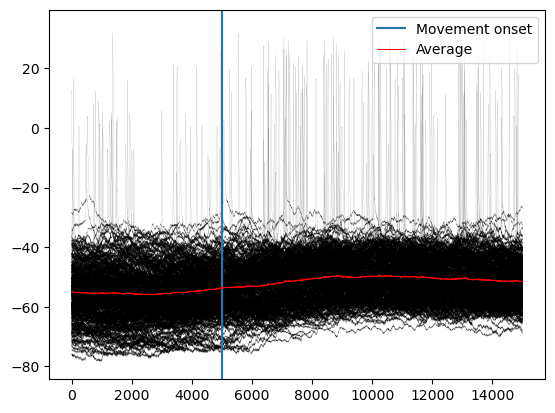

In [369]:
for i in event_data_before:
    plt.plot(i, linewidth = 0.05, color = 'black')

plt.axvline(x = 0.25 * 20000, label = 'Movement onset')
plt.plot(np.mean(event_data_before, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [370]:
onset_idx = int(0.25 * 20000)
print(f'Average signal before the event: {np.mean(event_data_before[ :, :onset_idx ])}')
print(f'Average signal during the event: {np.mean(event_data_before[ :, onset_idx: ])}')

Average signal before the event: -55.20837644270253
Average signal during the event: -50.95099072067652


In [371]:
event_data_after = read_event_data(sample_ids = samples['SID'], time_shift = 0.25, event_length = 0.5)

Too short
Too short
Too short
Too short
Too short
Too short


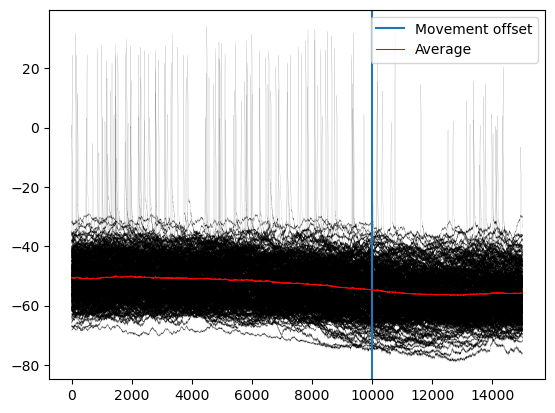

In [372]:
for i in event_data_after:
    plt.plot(i, linewidth = 0.05, color = 'black')
    
plt.axvline(x = 0.5 * 20000, label = 'Movement offset')
plt.plot(np.mean(event_data_after, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [373]:
offset_idx = int(0.5 * 20000)
print(f'Average signal during the event: {np.mean(event_data_after[ :, :offset_idx ])}')
print(f'Average signal after the event: {np.mean(event_data_after[ :, offset_idx: ])}')

Average signal during the event: -51.684153573262364
Average signal after the event: -55.93973066052258


In [374]:
data_before = event_data_before[ :, :onset_idx ]
data_during_early = event_data_before[ :, onset_idx: ]
data_during_late = event_data_after[ :, :offset_idx ]
data_after = event_data_after[ :, offset_idx: ]

In [375]:
dt = np.concatenate([
    np.mean(data_before, axis = 1),
    np.mean(data_during_early, axis = 1),
    np.mean(data_during_late, axis = 1),
    np.mean(data_after, axis = 1)
])

types = np.concatenate([
    np.repeat('Before', data_before.shape[0]),
    np.repeat('Early event', data_during_early.shape[0]),
    np.repeat('Late event', data_during_late.shape[0]),
    np.repeat('After', data_after.shape[0])
])

assert len(dt) == len(types)

dt = pd.DataFrame({
    'Median': dt,
    'Type': types
})

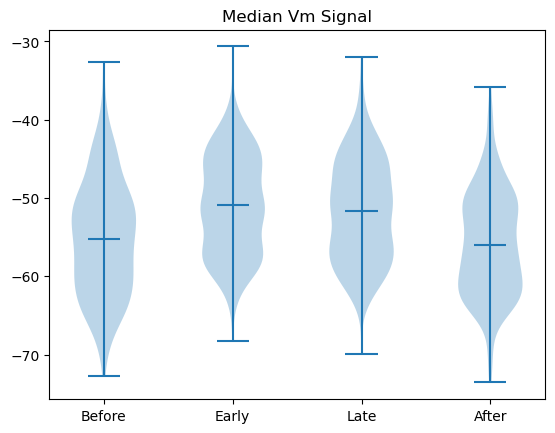

In [376]:
plt.violinplot([
    dt[dt['Type'] == 'Before']['Median'],
    dt[dt['Type'] == 'Early event']['Median'],
    dt[dt['Type'] == 'Late event']['Median'],
    dt[dt['Type'] == 'After']['Median']
], showmeans = True)

plt.xticks([1, 2, 3, 4], ['Before', 'Early', 'Late', 'After'])
plt.title('Median Vm Signal')
plt.show()

In [377]:
dt1 = dt[dt['Type'] == 'Before']['Median']
dt2 = dt[dt['Type'] == 'Early event']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: -7.709200539754866
P-value: 5.077753746571241e-14


Slight difference between before the event and during the event.

In [378]:
dt1 = dt[dt['Type'] == 'Early event']['Median']
dt2 = dt[dt['Type'] == 'Late event']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 1.4230013515360367
P-value: 0.15524035520355428


No difference between the start of event versus the end of event.

In [379]:
dt1 = dt[dt['Type'] == 'Late event']['Median']
dt2 = dt[dt['Type'] == 'After']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 8.067368890822035
P-value: 3.7463127331740515e-15


Slight difference between during the event and after the event.